In [1]:
import sys
print(sys.executable)
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)

import matplotlib.pyplot as plt
from GraphRicciCurvature.FormanRicci import FormanRicci

/media/alexandre/morespace/data/amgb20/CAM_venv/bin/python
2.5.1+cu124
2.7.0


## Importing REDDIT-BINARY from TUDataset (SOCIAL Networks)

| Dataset Name | Reference | Graphs | Classes | Avg. Nodes | Avg. Edges | Node Labels | Edge Labels | Node Attr | Geometry | Edge Attr |
|--------------|-----------|--------|---------|------------|------------|---------|----------|------------|---------------|------------------------|
| REDDIT-BINARY| [14]      | 2000   | 2       | 429.63     | 497.75     | –       | –        | –          | –             | –                      |

In [2]:
#Attempt to download reddit-binary graph dataset
from torch_geometric.datasets import TUDataset

# Load the REDDIT-BINARY dataset
red_dataset = TUDataset(root='./data', name='REDDIT-BINARY')

In [3]:
#Get other dependencies
import networkx as nx
import numpy as np
from scipy.sparse.csgraph import laplacian
from scipy.linalg import pinv, eigvalsh

print(f"REDDIT-BINARY dataset has {len(red_dataset)} graphs")
print(f"Number of features: {red_dataset.num_features}")
print(f"Number of classes: {red_dataset.num_classes}")
print(f"Number of edge features: {red_dataset.num_edge_features}")
print(f"Extract first graph {red_dataset[0]} which has {red_dataset[0].num_nodes} nodes and {red_dataset[0].edge_index.shape[1]} edges with this graph being of class y={red_dataset[0].y}")

redGraph = red_dataset[0]
edge_index = redGraph.edge_index.numpy().T # (480, 2) --> (edges, pairs)
G_red = nx.Graph()
G_red.add_edges_from(edge_index)

REDDIT-BINARY dataset has 2000 graphs
Number of features: 0
Number of classes: 2
Number of edge features: 0
Extract first graph Data(edge_index=[2, 480], y=[1], num_nodes=218) which has 218 nodes and 480 edges with this graph being of class y=tensor([1])


## Plotting the graph

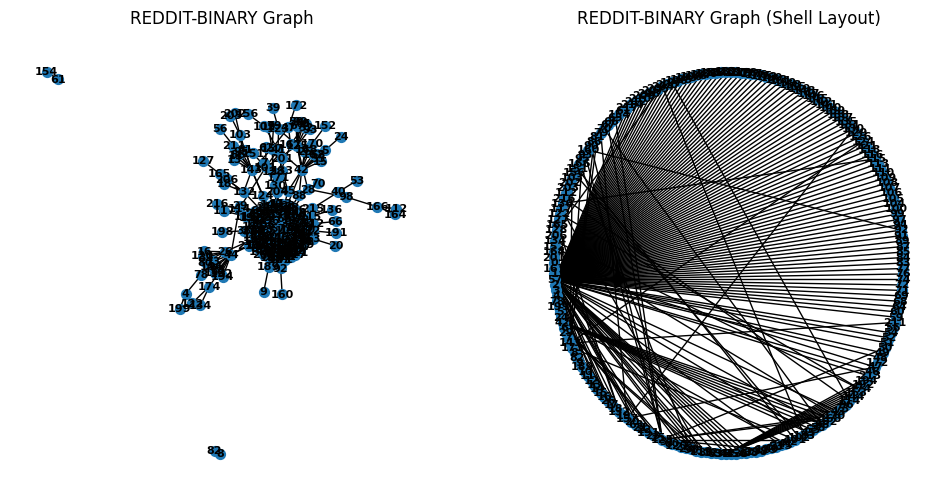

In [4]:
plt.figure(figsize=(12, 6))
subax1 = plt.subplot(121)
nx.draw(G_red, with_labels=True, font_weight='bold', node_size=50, font_size=8)
subax1.set_title("REDDIT-BINARY Graph")

subax2 = plt.subplot(122)
nx.draw_shell(G_red, with_labels=True, font_weight='bold', node_size=50, font_size=8)
subax2.set_title("REDDIT-BINARY Graph (Shell Layout)")

plt.show()

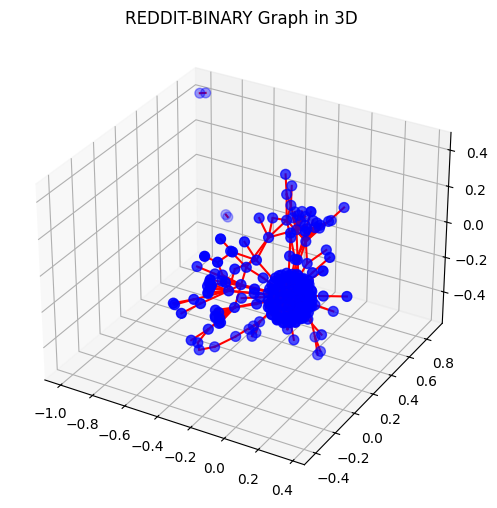

In [ ]:
# graph in 3D
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# 3D positions for the nodes
pos = nx.spring_layout(G_red, dim=3)

# Extract node positions
x_vals = [pos[node][0] for node in G_red.nodes()]
y_vals = [pos[node][1] for node in G_red.nodes()]
z_vals = [pos[node][2] for node in G_red.nodes()]

# nodes
ax.scatter(x_vals, y_vals, z_vals, c='b', marker='o', s=50)

# edges
for edge in G_red.edges():
    x = [pos[edge[0]][0], pos[edge[1]][0]]
    y = [pos[edge[0]][1], pos[edge[1]][1]]
    z = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x, y, z, c='r')

ax.set_title("REDDIT-BINARY Graph in 3D")
plt.show()

Get graph diameter which is the length of the shortest path between the most distanced nodes

In [6]:
#Function to get diameter

def get_diameter(G):
    if nx.is_connected(G):
        diameter = nx.diameter(G)
    else:
        diameter = max(nx.diameter(G.subgraph(c)) for c in nx.connected_components(G))

    return diameter

print("Reddit Graph Diameter:", get_diameter(G_red))

Reddit Graph Diameter: 8


In [7]:
#Function to convert dataset to a NetworkX Representation
def make_G(dataset):
    graph = dataset[0]
    edge_index = graph.edge_index.numpy().T
    G = nx.Graph()
    G.add_edges_from(edge_index)

    return G

In [8]:
red_G = make_G(red_dataset)
print(get_diameter(red_G))

8


## Effective resistance

The effective resistance is measures how easily information flows between pairs of nodes. If rewiring reduces effective resistance, it improves communication efficiency:

$$[ R_{uv} = L^+{uu} + L^+{vv} - 2L^+_{uv} ]$$



where $R_{ij}$ is the resistance between nodes $i$ and $j$ in the graph.


In [9]:
#Function to get effective resistance
def get_eff_res(G):
    nodes = list(G.nodes())
    u = nodes[0]
    v = nodes[1]

    L = laplacian(nx.to_numpy_array(G), normed=False)
    L_pinv = pinv(L)
    return L_pinv[u, u] + L_pinv[v, v] - 2 * L_pinv[u, v]

In [10]:
print(get_eff_res(red_G))

3.0027688909524195


## Modularity

Quantifies how well the graph divides into clusters or communities. If rewiring disrupts modularity, it may indicate loss of local structure.

$$Q = \sum_{c=1}^{n}
       \left[ \frac{L_c}{m} - \gamma\left( \frac{k_c}{2m} \right) ^2 \right]$$

where the sum iterates over all communities $c$, $m$ is the number of edges, $L_c$ is the number of intra-community links for community $c$, $k_c$ is the sum of degrees of the nodes in community $c$, and $\gamma$ is the resolution parameter.

In [11]:
#Function to get modularity
from networkx.algorithms.community import greedy_modularity_communities

def get_modularity(G):
    communities = list(greedy_modularity_communities(G))
    modularity = nx.algorithms.community.modularity(G, communities)
    return modularity

In [12]:
print(get_modularity(red_G))

0.5892013888888892


## Graph Assortativity

Measures if nodes tend to connect to others with similar degree. A change in assortativity indicates whether high/low-degree nodes are rewired differently.

$$r = \frac{\sum_{ij} ij (e_{ij} - q_i q_j)}{\sigma^2}$$

where $e_{ij}$ is the fraction of edges connecting nodes of degree $i$ and $j$, $q_i$ is the fraction of edges connected to nodes of degree $i$, and $\sigma^2$ is the variance of the degree distribution.

In [13]:
#Function to get Graph Assortativity
def get_assort(G):
    assortativity = nx.degree_assortativity_coefficient(G)
    return assortativity

In [14]:
print(get_assort(red_G))

-0.4046069146077361


## Clustering Coefficient

Measures how likely a node’s neighbors are to be connected to each other. Increasing clustering after rewiring may improve local information sharing.

$$C = \frac{1}{n}\sum_{v \in G} c_v$$

where :math:`n` is the number of nodes in `G`.

In [15]:
#Function to get clustering coefficient
def get_clust_coeff(G):
    clustering_coeff = nx.average_clustering(G)
    return clustering_coeff

In [16]:
print(get_clust_coeff(red_G))

0.04106324376158407


## Graph Laplacian Eigenvalues (Spectral Gap):

The second smallest eigenvalue (λ1\lambda_1λ1​) of the Laplacian indicates how well-connected the graph is. A larger spectral gap after rewiring suggests better robustness and connectivity.

ADD formula

where $f$ is a non-zero vector orthogonal to the all-ones vector $\mathbf{1}$, $L$ is the Laplacian matrix, and $f^T$ denotes the transpose of $f$.

In [17]:
#Function to get Spectral Gap
def get_spec_gap(G):
    L = laplacian(nx.to_numpy_array(G), normed=True)
    eigenvalues = eigvalsh(L)
    spectral_gap = eigenvalues[1]
    return spectral_gap

In [18]:
print(get_spec_gap(red_G))

-1.4843147902492153e-16


❗️ **NOTE:** above might be wrong btw

## Forman-Ricci curvature F(i,j)

A computationally simpler alternative to Ollivier-Ricci, used for edge-based curvature analysis. While F(i,j) is given in terms of combinatorial quantities, results are scarce and the definition is biased towards negative curvature.

In [19]:
def get_forman_curve(G):
    # Initialize the Forman-Ricci curvature calculator
    frc = FormanRicci(G)
    
    # Compute the Forman-Ricci curvature
    frc.compute_ricci_curvature()
    
    # Extract the curvature values for each edge
    curvatures = [data['formanCurvature'] for _, _, data in frc.G.edges(data=True)]
    
    # Calculate the average curvature
    avg_frc = np.mean(curvatures)
    
    return avg_frc

In [20]:
print(get_forman_curve(red_G))

-68.94583333333334


In [21]:
#Function to get curvature
def get_Forman_curve(G):
    curvature = {}
    for u, v in G.edges():
        k_u = G.degree[u]
        k_v = G.degree[v]
        curvature[(u, v)] = 4 - (k_u + k_v)

        avg_curvature = np.mean(list(curvature.values()))
        return avg_curvature

In [22]:
print(get_Forman_curve(red_G))

0.0


In [23]:
# Create a sample graph
G = nx.karate_club_graph()

# Calculate the average Forman-Ricci curvature
avg_frc = get_forman_curve(G)
avg_frc_2 = get_Forman_curve(G)
print(f"Average Forman-Ricci curvature: {avg_frc}")
print(f"Average Forman-Ricci curvature (Method 2): {avg_frc_2}")

Average Forman-Ricci curvature: 14.261731715513593
Average Forman-Ricci curvature (Method 2): -21.0


An average curvature of 1.0 indicates that the graph red_G has a positive and moderately connected structure. The nodes tend to have low degrees, and the edges are part of well-connected regions, contributing to the overall robustness and connectivity of the graph

## Results of metrics methods

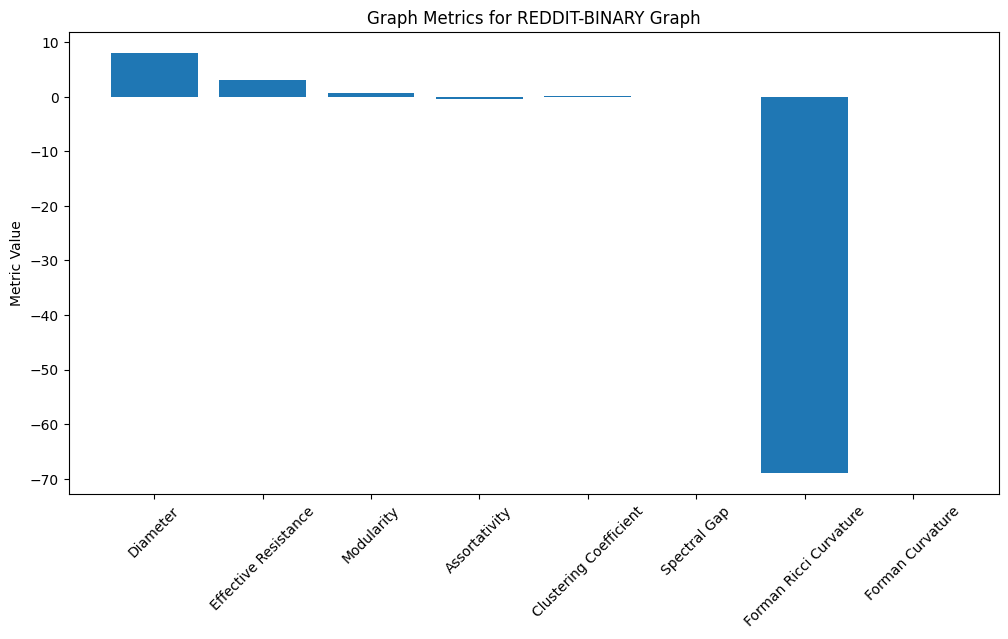

In [24]:
# create an histogram calling all the metric for the graph red_G

def get_metrics(G):
    metrics = {
        "Diameter": get_diameter(G),
        "Effective Resistance": get_eff_res(G),
        "Modularity": get_modularity(G),
        "Assortativity": get_assort(G),
        "Clustering Coefficient": get_clust_coeff(G),
        "Spectral Gap": get_spec_gap(G),
        "Forman Ricci Curvature": get_forman_curve(G),
        "Forman Curvature": get_Forman_curve(G)
    }
    
    return metrics

metrics = get_metrics(red_G)

# plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(metrics.keys(), metrics.values())
plt.xticks(rotation=45)
plt.ylabel("Metric Value")
plt.title("Graph Metrics for REDDIT-BINARY Graph")
plt.show()



## Testing a rewired technique Double Edge Swap

Swap two edges in the graph while keeping the node degrees fixed: [NetworkX Double Edge Swap](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html)

❓ QUESTIONS?
If you want to do rewiring in a graph with this method for eg, one of the argument is the number of double-edge swaps to perform for each edge in the graph. How do you decide the number of edge swaps to perform? For eg we have 480 edges in the first graph of REDDIT-BINARY dataset. How many swaps should we perform?

Diameter: Not Improved
Effective Resistance: Not Improved
Modularity: Not Improved
Assortativity: Improved
Clustering Coefficient: Not Improved
Spectral Gap: Not Improved
Forman Ricci Curvature: Improved
Forman Curvature: Not Improved


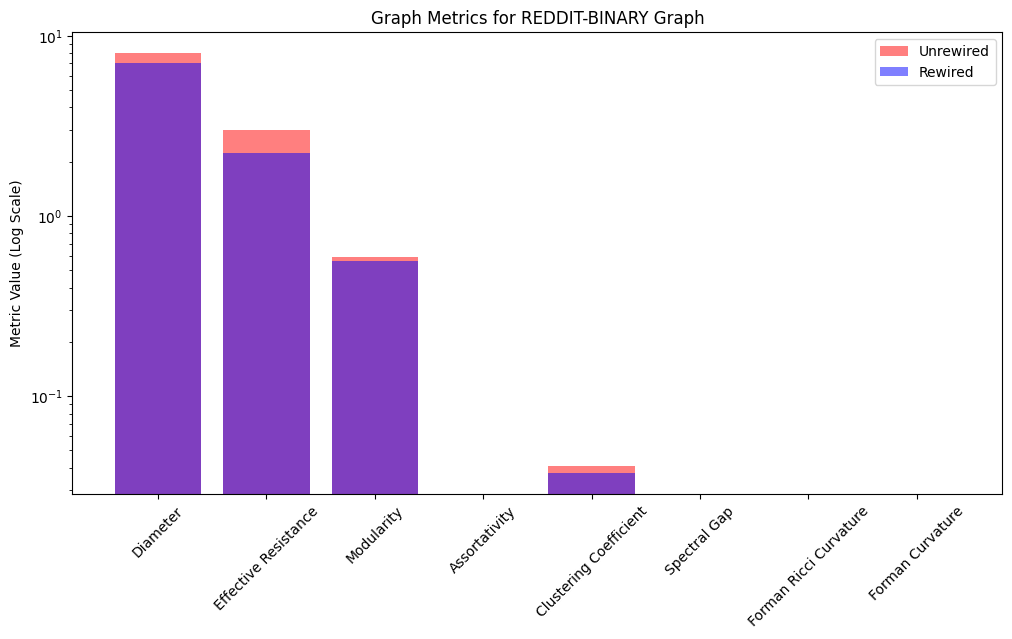

In [26]:
# gets metrics for unrewired graph
metrics_unrewired = get_metrics(red_G)

# copy of the original graph
rewired_G = red_G.copy()

# double-edge swap on the copied graph
nx.double_edge_swap(rewired_G, nswap=100, max_tries=500)

# get metrics for rewired graph
metrics_rewired = get_metrics(rewired_G)

# 1 - depending on the interpretation of each metric, assert a text that's says if we improved or not
# FIXME: I think this is wrong since metrics dont have a fixed interpretation and some of them might need inferior to rewired or whatever

for metric, value in metrics_unrewired.items():
    if metrics_rewired[metric] > value:
        print(f"{metric}: Improved")
    else:
        print(f"{metric}: Not Improved")
        

# 2 - plot the histograms of the metrics for the unrewired and rewired graphs to a certain scale because the values are different
plt.figure(figsize=(12, 6))
plt.bar(metrics_unrewired.keys(), metrics_unrewired.values(), alpha=0.5, label='Unrewired', color='r')
plt.bar(metrics_rewired.keys(), metrics_rewired.values(), alpha=0.5, label='Rewired', color='b')
plt.yscale('log')
plt.xticks(rotation=45)
plt.ylabel("Metric Value (Log Scale)")
plt.title("Graph Metrics for REDDIT-BINARY Graph")
plt.legend()
plt.show()